#PTUT tests


In [18]:
%matplotlib notebook   


import qiskit

import numpy as np

seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt

%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
# from qiskit.circuit.library import TwoLocal, UniformDistribution #deprecated
from qiskit.circuit.library import TwoLocal

from qiskit_finance.circuit.library import UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

modeItems = [
    ("QNUMBER", "Number of Qubits", "Create quantum circuit from number of quibts", "", 0) #,
    #("QCNUMBER", "Number of Qubits and Bits", "Create quantum circuit from number of quibts and number of bits", "", 1)
]


bl_idname = "an_qGAN"
bl_label = "qGAN Processing"


    # ------------- LOAD THE TRAINING DATA --------------

# Number training data samples
N = 100 # Was 1000 before but took too long

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.0, 3.0])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

print(real_data)

[ 6.94584328  2.24963995  0.8665988   2.73249245  1.16804977  2.03468285
  0.52190913  2.08913633  0.6529956   4.71738126  1.75494616  4.65804078
 14.10892985  2.00798309  1.87578703  1.46786668 11.16635613  1.86245978
  1.42082865  2.07611949  4.67428242 19.87319657  1.19245273  1.58181296
  1.02204239 14.94116714  0.32907176  8.74887229  3.96355591  3.36035946
  1.70838847  1.4770478   2.27578676  5.71964386  2.18582366  0.62530567
  4.5343021   4.90517089  1.68224387  3.24862394  0.7452621   3.09229936
 19.03136178  6.19164165  1.15177464  0.74411811  7.14768978 54.60066077
  2.6843979   3.65907677  1.05671495 18.3435993   8.83996264  0.33686721
 17.04815602  2.44223435  7.22735021  3.50516256  2.05554129 30.10859741
  1.64037014 12.18720912  9.82637253  1.84303446  3.15216155  0.61815389
  3.31091306  7.41359553  3.90502227  6.72163149  0.71123652  5.6547542
  5.76691453  3.11432782  5.87222546  4.95051285  0.31073857  1.86141132
  1.31829508  1.50132705  0.33162601  0.76442092  8.

  # Initialize the qGAN

In [21]:
        # Set number of training epochs
        # Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
        num_epochs = 10
        # Batch size
        batch_size = 50 # Was 100 before

        # Initialize qGAN
        qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
        qgan.seed = 1
        # Set quantum instance to run the quantum generator
        quantum_instance = QuantumInstance(
            backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
        )

        # Set entangler map
        entangler_map = [[0, 1]]


        # Set an initial state for the generator circuit
        init_dist = UniformDistribution(sum(num_qubits))

        # Set the ansatz circuit
        ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement=entangler_map, reps=1)

        # Set generator's initial parameters - in order to reduce the training time and hence the
        # total running time for this notebook
        init_params = [3.0, 1.0, 0.6, 1.6]

        # You can increase the number of training epochs and use random initial parameters.
        # init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

        # Set generator circuit by adding the initial distribution infront of the ansatz
        g_circuit = ansatz.compose(init_dist, front=True)

        # Set quantum generator
        qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
        # The parameters have an order issue that following is a temp. workaround
        qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
        # Set classical discriminator neural network
        discriminator = NumPyDiscriminator(len(num_qubits))
        qgan.set_discriminator(discriminator)

# Run the qGAN training

In [22]:
        # Run qGAN
        result = qgan.run(quantum_instance)

        print("Training results:")
        for key, value in result.items():
            print(f"  {key} : {value}") # TODO : Print this data in a viewer node in Blender


        # return num_epochs, bounds #specific to QN add-on code (not for notebook)

Training results:
  params_d : [ 0.02646114  0.62070005 -0.48919575 ... -0.17645709 -0.19133291
 -0.09736615]
  params_g : [2.9900023  0.99000126 0.59000119 1.60999957]
  loss_d : 0.7297
  loss_g : [0.9849]
  rel_entr : 0.1119


# Training Progress & Outcome 

## Histogramme target - tests




In [23]:
log_normal = np.random.lognormal(mean=1, sigma=1, size=20)
print("log_normal = ", log_normal)
log_normal = np.round(log_normal)
print("log_normal = ", log_normal)
bounds = np.array([0.0, 3.0])
log_normal = log_normal[log_normal <= bounds[1]]
print("log_normal = ", log_normal)

temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal == i)]
print("temp = ",temp)
log_normal = np.array(temp / sum(temp))
cum_log_normal = np.cumsum(log_normal)
print("log_normal = ", log_normal)

targetCounts = {}
for i in range(len(cum_log_normal)) :
    targetCounts[str(i)] = cum_log_normal[i]
    
print("cum_log_normal = ", cum_log_normal)
print("targetcounts = ", targetCounts)

log_normal =  [ 3.34537696  2.12523135  0.78707392  4.70833366  3.32230287  5.24584376
  3.64329826  1.82340176  2.29695335  3.06495603  3.0212923   1.65493258
  9.33259496  1.05205122  4.6757836   6.68817932  2.47953234  4.42974171
  7.69576019 16.10854502]
log_normal =  [ 3.  2.  1.  5.  3.  5.  4.  2.  2.  3.  3.  2.  9.  1.  5.  7.  2.  4.
  8. 16.]
log_normal =  [3. 2. 1. 3. 2. 2. 3. 3. 2. 1. 2.]
temp =  [0, 2, 5, 4]
log_normal =  [0.         0.18181818 0.45454545 0.36363636]
cum_log_normal =  [0.         0.18181818 0.63636364 1.        ]
targetcounts =  {'0': 0.0, '1': 0.18181818181818182, '2': 0.6363636363636364, '3': 1.0}


# Histogramme du *générateur* - tests

In [28]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
print("samples_g = ", samples_g)
samples_g = np.array(samples_g)
print("samples_g = ", samples_g)
samples_g = samples_g.flatten()
print("samples_g = ", samples_g)
print(prob_g)

cum_prob_g = np.cumsum(prob_g)
#num_bins = len(prob_g) # seems useless
#plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0)) # TO BE REMOVED (was for matplotlib graph)
simulationCounts = {}
for i in range(len(cum_prob_g)) :
    simulationCounts[str(samples_g[i])] = cum_prob_g[i]

print("simulationcounts = ", simulationCounts)

samples_g =  [[0.0], [1.0], [2.0], [3.0]]
samples_g =  [[0.]
 [1.]
 [2.]
 [3.]]
samples_g =  [0. 1. 2. 3.]
[0.012259080421668752, 0.5455212368706617, 0.19510090606177277, 0.24711877664589688]
simulationcounts =  {'0.0': 0.012259080421668752, '1.0': 0.5577803172923305, '2.0': 0.7528812233541032, '3.0': 1.0}


# Tests divers

In [25]:
print(type(bounds))
print(type(qgan))

<class 'numpy.ndarray'>
<class 'qiskit_machine_learning.algorithms.distribution_learners.qgan.qgan.QGAN'>


In [26]:
test = QGAN([1], np.array([1.0, 2.0]), [1], 1, 1, snapshot_dir=None)

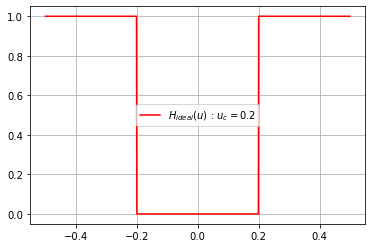

In [6]:
def GabaritPasseHaut(u,uc):
    return 1*(np.abs(((u+0.5)%1 - 0.5))>uc)

u=np.arange(-0.5,0.5,0.001)
uc=0.2
y=GabaritPasseHaut(u,uc)
plt.figure(1)
plt.plot(u,y,'r',label=r'$H_{ideal}(u)$ : $u_c=0.2$')
plt.legend(loc='center')
plt.grid()
plt.show()
    

Ce filtre est associé à la Réponse Impulsionnelle (RI)
\begin{equation}
\begin{cases}
h_{\text{ideal}}[0] & =1-2 u_{c}\\
h_{\text{ideal}}[n] & =-\frac{\sin(2\pi n u_{c})}{\pi n}\ \text{si }n\neq0.
\end{cases}
\end{equation}
Cette dernière a été calculée par intégration : 
$$
h_{\text{ideal}}[n]=\int_{-1/2}^{1/2}H_{\text{ideal}}(u)e^{i2\pi n u }du.
$$


C'est une suite non-causale et non-stable. 
Néanmoins, c'est à partir de cette RI que l'on conçoit un filtre de RI notée $h[n]$,  **RIF**, **causal** (et évidemment stable comme tous les filtres RIF). 
Dans toute la suite, $N$ désigne l'ordre de ce filtre c'est-à-dire que les seuls coefficients non-nuls de $h[n]$ sont 
$$
h[n] \ \ , \ \ n\in \{0,1,...,N\}.
$$
(c'est donc un filtre à **$N+1$ coefficients**). 
Nous supposerons enfin que **$N$ est un nombre pair** et nous noterons 
$$
N=2M.
$$

Soit $w[n]$ une fenêtre d'ordre $N$, c'est une suite  causale, positive ayant $N+1$ coefficients : 
$$
w[n]=0 \ \ \text{ si } \ \ n\notin \{0,1,...,N\}.
$$
On définit alors le filtre 
$$
h[n]=h_{\text{ideal}}[n-M]w[n].
$$


Voici représenté le passage de la RI  $h_{\text{ideal}}[n]$ à $h[n]$ (nous avons choisi $N=20$ et $u_c=0.2$) lorsque la fenêtre choisie est la fenêtre rectangulaire (c'est-à-dire la fenêtre $w[n]=1$ pour tout $n\in\{0,1,...,N\})$. 


In [ ]:
def RI_ideal(n,uc):
    h=0.0*n  ### vecteur de même taille que n
    h[n==0]=1-2*uc
    h[n != 0]=1/(np.pi*n[n != 0])*(-np.sin(2*np.pi*n[n != 0]*uc))
    return h

M=10
N=2*M
uc=0.2
indices=np.arange(-20,21)
indices_tronc=np.arange(-M,M+1)
h_ideal=RI_ideal(indices,uc)
h=RI_ideal(indices_tronc,uc)
plt.figure(2)
plt.subplot(211)
plt.plot(indices,h_ideal,'-o',label=r'$h_{ideal}[n]$ : suite infinie non causale')
plt.legend(loc='upper left')
plt.grid()
plt.subplot(212)
plt.plot(indices_tronc+M,h,'-o',label=r'$h[n]$ : RIF causal pour $M=10$')
plt.axvline(x=M,linestyle='--',label=r'$M=10$')
plt.legend(loc='upper left')
plt.grid()





Le gain de ce filtre associé à la fenêtre rectangulaire  peut être étudié analytiquement (ceci est un travail assez pénible que nous éviterons cette année). Voici son graphe (nous avons choisi $N=24$ et $u_c=0.2$) : 

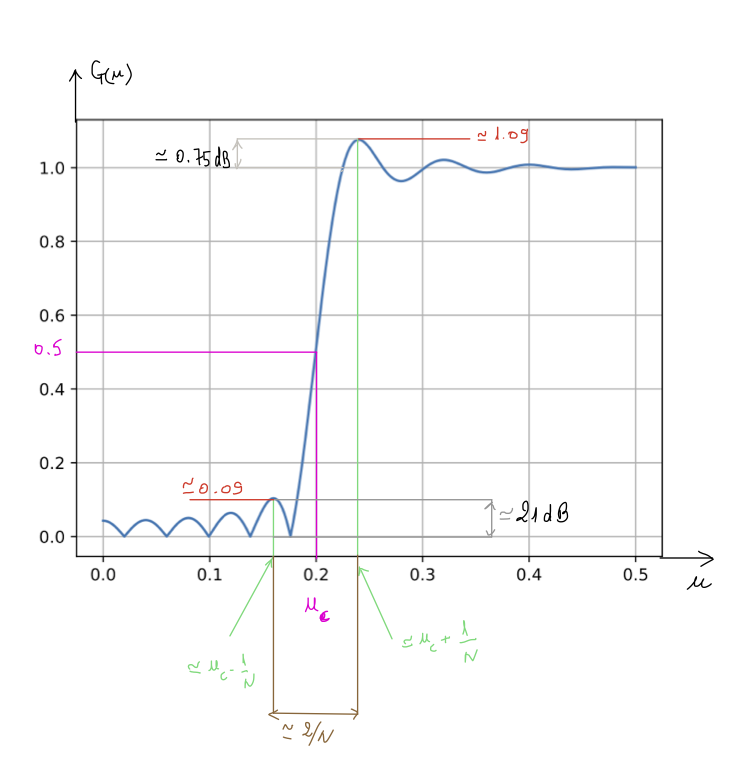
On définit la **bande de transition comme l'intervalle entre la fréquence de l'oscillation la plus haute à gauche de $u_c$ et la fréquence de l'oscillation la plus haute à droite de $u_c$.**    On montre que cette bande, que nous noterons $\Delta u$ vérifie : 
$$
\Delta u \simeq \frac{2}{N}.
$$
L'atténuation en bande de coupure est $21dB$ et en bande passante de $0.75dB$. 



### Question no 1 
Les quelques lignes de code qui suivent vous permettent 
de retrouver le gain du filtre  RIF passe-bas  obtenu 
par la méthode de la fenêtre rectangulaire 
(on parle dans de cas de méthode de la troncature). 
Inspirez-vous en pour répondre aux questions. 

- ($N=30$) Dessinez le graphe des fenêtres de Hamming et Blackmann : vous vous servirez des routines 
$\texttt{signal.hamming(N+1)}$ et $\texttt{signal.blackman(N+1)}$
- ($N=30$, $u_c=0.2$) Dessinez le gain obtenu pour les fenêtres rectangulaire, de Hamming et Blackmann. Calculez à partir des graphiques pour chacun des gains obtenus : la bande de transition, les atténuations (en décibels) en bande passante et en bande de coupure. 

- On trouve dans les livres les valeurs suivantes 

$$
\begin{array}{cccc}
 & \text{bande de transition }\Delta u & \text{Atténuation (bande passante) } & \text{Atténuation (bande de coupure) }\\
\text{fenêtre rectangulaire } & 2/N & 0.75dB & 21dB\\
\text{fenêtre de Hamming} & 4/N & 0.019dB & 53dB\\
\text{fenêtre de Blackman} & 6/N & 0.0017dB & 74dB
\end{array}
$$
Ces résultats sont-ils cohérents avec ceux mesurés dans la question précédente? 
Ceci indique le compromis suivant : soit on privilégie une bande de coupure étroite (le minimum est $2/N$) au prix d'une atténuation en bande de coupure médiocre ou bien on privilégie une très forte atténuation en bande de coupure au prix d'une bande de transition large. On ne peut pas tout avoir...




In [ ]:
M=15
N=2*M
uc=0.2
n=np.arange(-M,M+1)
h=RI_ideal(n,uc)



wR=np.ones(N+1)
wH=signal.hamming(N+1)
wB=signal.blackman(N+1)
hH=h*wH
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1
freqs, GR , Phase_R=Bode(h,D)
freqs, GH , Phase_H=Bode(hH,D)
freqs, GB , Phase_B=Bode(hB,D)
                

plt.figure(3)
plt.clf()
plt.plot(wR,'o',label='rectangulaire')
plt.plot(wH,'o',label='Hamming')
plt.plot(wB,'o',label='Blackman')
plt.legend()
plt.title('graphe de trois fenêtres')


plt.figure(4)
plt.plot(freqs,GR,label='rectangulaire')
plt.plot(freqs,GH,label='Hamming')
plt.plot(freqs,GB,label='Blackman')
plt.legend()
plt.grid()
plt.legend(loc=4)
plt.title('Gains obtenus pour N=30')
plt.show()



In [ ]:
M=50
N=2*M
uc=0.2
n=np.arange(-M,M+1)
h=RI_ideal(n,uc)



wR=np.ones(N+1)
wH=signal.hamming(N+1)
wB=signal.blackman(N+1)
hH=h*wH
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1
freqs, GR , Phase_R=Bode(h,D)
freqs, GH , Phase_H=Bode(hH,D)
freqs, GB , Phase_B=Bode(hB,D)
                


plt.figure(5)
plt.plot(freqs,GR,label='rectangulaire')
plt.plot(freqs,GH,label='Hamming')
plt.plot(freqs,GB,label='Blackman')
plt.legend()
plt.grid()
plt.legend(loc=4)
plt.title('Gains obtenus pour N=100')
plt.show()


### Question no 2 

Dans cette question, on souhaite filtrer le signal  $\texttt{Traverso.wav}$ : le filtre en question est justement un filtre passe-haut dont nous allons donner les caractéristiques.  
   
   On rappelle que le signal en question est un mélange de sinusoïdes dont les fréquences sont des multiples de 
   $$
   u_0=\frac{f_0}{F_e}
   $$
   où $f_0=364$Hz et $F_e=44100$Hz. 
   
   On souhaite atténuer très significativement (dans une proportion supérieure à $60$dB) le fondamental de ce signal (la composante à la fréquence $u_0$) en ne modifiant les amplitudes des autres composantes que dans une proportion inférieure à $0.5$dB. 
   
- Proposer un filtre RIF qui accomplit cette tâche. Vous préciserez l'ordre, la fenêtre utilisée.

Réponse : on prend comme fréquence de coupure la fréquence située à égale distance de 
$u_0$ et $2u_0$, soit
$$
u_c= \frac{3}{2} u_0.
$$
Il s'agit ensuite de définir le type de fenêtre et l'ordre du filtre. POur obtenir comme souhaité une atténuation d'au moins $60dB$ dans la bande d'atténuation, il faut si l'on se réfère au tableau "officiel" précédent choisir une fenêtre de Blackman. Quant à son ordre, on le choisit pour que la bande d'atténuation coïncide avec l'intervalle $[u_0,2u_0]$ ce qui donne la relation 
$$
\frac{6}{N}\leq 2u_0-u_0
$$
ou encore 
$$
N\geq \frac{6F_e}{440}= 727.
$$
Nous prendrons $N=728$ (il faut que $N$ soit pair). Remarquez que ce filtre est long. 

- Filtrer le signal (fonction $\texttt{signal.convolve}$) et dessiner dans deux graphes distincts les périodogrammes des deux signaux (filtré et non-filtré). Le filtre a-t-il agi comme ce à quoi nous nous attendions? 

- Concertir le signal filtré en *wave* et écouter le résultat obtenu. Entendez-vous encore la hauteur du signal d'origine? 

Voici ce que l'on peut lire dans l'histoire de la musique (édition de La Pléïade, article de Jacques Brillouin “l'acoustique et la musique”, pages  39) : 

*La hauteur d'un son musical, pur ou complexe, résulte donc du fait que l'oreille informe le cerveau de la présence d'une série harmonique; la hauteur attribuée au son est celle de la fondamentale de cette série même si cette dernière n'existe pas dans le son proposé à l'oreille; les conséquences musicales de ce fait sont importantes. Trois harmoniques successifs, fussent-ils de rang élevé (8, 9 et 10 par exemple), sont entendus comme un son unique dont la hauteur est celle de la fondamentale.*

In [ ]:
###  le filtre passe-haut
f0=364
Fe=44100
u0=f0/Fe
uc=3/2*u0
M=int (((6*Fe/f0)//2) + 1)
N=2*M
print(N)
n=np.arange(-M,M+1)
h=RI_ideal(n,uc)
wB=signal.blackman(N+1)
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1

freqs, G, Phase = Bode(hB,D)

plt.figure(7)

plt.subplot(211)
plt.plot(h)
plt.subplot(212)
plt.plot(freqs,(G))
plt.show()



#### le signal d'entrée
Fe, x = io.read('Traverso.wav')
#####  le filtrage
y=signal.convolve(hB,x)

####les périodogrammes
frequences_x , I_x = Periodogramme_dB(x)
frequences_y , I_y = Periodogramme_dB(y)
frequences_x=frequences_x*Fe
frequences_y=frequences_y*Fe

plt.figure(8)
plt.clf
plt.subplot(211)
indices=frequences_x<2000
plt.plot(frequences_x[indices],I_x[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.subplot(212)
indices=frequences_y<2000
plt.plot(frequences_y[indices],I_y[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.show()





Coder_WAV('FiltragePH.wav',y,Fe)
audio = Audio(filename='./FiltragePH.wav')
display(audio)
audio = Audio(filename='./Traverso.wav')
display(audio)

In [ ]:
print(M)

### Question no 3

Afin d'illustrer la dernière phrase de J. Brilloin, on se propose de filtrer le signal de violon par un filtre passe-bande. 

- Montrer que le filtre $Q_{\text{ideal}}(u)=1- H_{\text{ideal}}(u)$ est un filtre passe-bas dont la fréquence de coupure est $u_c$. 

- Appelons $q_{\text{ideal}}[n]=\delta[n]-h_{\text{ideal}}(n)$ la RI de ce filtre et donnons-nous une fréquence $0<u_1<1/2$. Calculer en fonction de $Q_{\text{ideal}}$ et $u_1$ la fonction de transfert $R_{\text{ideal}}(u)$ du filtre 
$$
r_{\text{ideal}}[n]=2 q_{\text{ideal}}[n]\cos(2\pi n u_1).
$$

- Montrer que si les conditions 
$$
\begin{cases}
-u_{c}+u_{1}>0 & \text{ et}\\
u_{c}+u_{1}<\frac{1}{2}
\end{cases}
$$
sont réalisées alors le filtre de fonction de transfert $R_{\text{ideal}}(u)$ est un filtre passe-bande dont la bande passante est $\left[ -u_{c}+u_{1} \ , \ u_{c}+u_{1} \  \right]$.

- Synthétiser alors un filtre RIF permettant d'extraire les harmoniques 8, 9 et 10 qui atténue à au moins $60$dB les composantes dans les bandes de coupure.

- Tester ce filtre sur le signal de violon et écouter le résultat. L'expérience permet-elle de confirmer le propos de J. Brillouin? 

Preuve des points : voir cours. 
Application : 
on choisit $-u_c+u_1=9u_0 - \frac{1}{2}u_0$ et $u_c+u_1=11 u_0 + \frac{1}{2}u_0$


In [ ]:
def RI_idealPB(n,uc):
    h=0.0*n  ### vecteur de même taille que n
    h[n==0]=2*uc
    h[n != 0]=1/(np.pi*n[n != 0])*(np.sin(2*np.pi*n[n != 0]*uc))
    return h


u1= 10*u0
uc=1.5*u0
n=np.arange(-M,M+1)
h=RI_idealPB(n,uc)
h=2*h*np.cos(2*np.pi*u1*n)
wB=signal.blackman(N+1)
hB=h*wB
D=np.repeat(0,N+1)
D[1]=1

freqs, G , Phase = Bode(hB,D )

plt.figure(9)
plt.clf()
plt.subplot(211)
plt.plot(h)
plt.subplot(212)
plt.plot(freqs,(G))
plt.show()

y=signal.convolve(hB,x)

####les périodogrammes
frequences_x , I_x = Periodogramme_dB(x)
frequences_y , I_y = Periodogramme_dB(y)
frequences_x=frequences_x*Fe
frequences_y=frequences_y*Fe
plt.figure(10)
plt.clf
plt.subplot(211)
indices=frequences_x<7000
plt.plot(frequences_x[indices],I_x[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.subplot(212)
indices=frequences_y<7000
plt.plot(frequences_y[indices],I_y[indices])
plt.xlabel('Fréquences en Hz')
plt.ylabel('DSP en décibels')
plt.grid()
plt.show()



#### Enregistrement 

Coder_WAV('FiltragePasseBande.wav',y,Fe)
audio = Audio(filename='./FiltragePasseBande.wav')
display(audio)
audio = Audio(filename='./Traverso.wav')
display(audio)

